<a href="https://colab.research.google.com/github/ImajiPietersz/FYP/blob/main/All_Feature_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

DATASET_PATH = '/content/drive/MyDrive/FYP18-machine-vibration-source-separation/ LoRaWAN dataset/machine_2_with_Noise_sensor1.csv'

COLUMNS_TO_IMPORT = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis', 'XCrestFactor', 'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement', 'YOAVelocity', 'YPeakmg', 'YRMSmg', 
           'ZOAVelocity', 'ZPeakmg', 'ZRMSmg', 'target']
X_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis', 'XCrestFactor', 'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement', 'YOAVelocity', 'YPeakmg', 'YRMSmg', 
         'ZOAVelocity', 'ZPeakmg', 'ZRMSmg']

TAR_COL = 'target'

df = pd.read_csv(DATASET_PATH)[COLUMNS_TO_IMPORT]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
features =COLUMNS_TO_IMPORT
features.remove('target')

In [ ]:
def generateFrames(size = 6,overlap = True):

  list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0, len(df), 1 if overlap else size) if i < len(df) - size]
  
  data = []
  labels = []

  for d in list_of_dfs:
    if(len(d)==size):
      values = d[features].values.flatten()
      min_val = tf.reduce_min(values)
      max_val = tf.reduce_max(values)
      values = (values - min_val) / (max_val - min_val)
      data.append(values)

      # FIX HERE label as 1 if not noisy false otherwise
      labels.append(d['target'].sum() < 2)

  labels = np.asarray(labels, dtype=bool) 
  data = np.array(data)

  return (data,labels)

In [ ]:
def splitTrainTest(ratio, data, labels):
  
  x_train, x_test,_ = np.split(data, [round(len(data) * ratio), len(data)])
  labels_train, labels_test,_ = np.split(labels, [round(len(labels) * ratio), len(labels)])

  return (x_train,labels_train, x_test,labels_test)

In [ ]:
frames, labels = generateFrames(12)
train_data, train_labels, test_data, test_labels = splitTrainTest(0.7, frames, labels)

In [ ]:
def plotUsingAutoEncoder(model):
  size = 12
  list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0, len(df), 12) if i < len(df) - 12]
    
  denoised = []

  for d in list_of_dfs:
    if(len(d) == size):
      values = d[features].values.flatten()
      min_val = tf.reduce_min(values)
      max_val = tf.reduce_max(values)
      values = (values - min_val) / (max_val - min_val)
      encoded_data = model.encoder( np.array([values])).numpy()
      [values] = model.decoder(encoded_data).numpy()
      values = (np.array(values) * (max_val - min_val).numpy())   + min_val.numpy()
      denoised = np.concatenate((np.array(denoised) , np.array(values)))

  denoised = np.reshape(np.array(denoised), (-1, len(features)))

  column_names=['denoised_XOAVelocity', 'denoised_XPeakmg', 'denoised_XRMSmg', 'denoised_XKurtosis', 'denoised_XCrestFactor', 'denoised_XSkewness', 'denoised_XDeviation', 'denoised_XPeaktoPeakDisplacement', 'denoised_YOAVelocity', 'denoised_YPeakmg', 'denoised_YRMSmg', 
         'denoised_ZOAVelocity', 'denoised_ZPeakmg', 'denoised_ZRMSmg']
  df_1 = pd.DataFrame(denoised, columns=column_names) 
  
  df_1.to_csv('denoised_velocities.csv')

  noise = np.reshape(df[features].values.flatten(), (-1, len(features)))

  plt.figure(figsize=(20,5)) 
  plt.plot(noise)
  plt.plot(denoised, color="red")
  plt.legend(labels=["Input", "Reconstruction"])
  plt.show()

In [ ]:
class Discriminator(Model):
   def __init__(self):
    super(Discriminator, self).__init__()
    self.model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(features)*12,) ),
        tf.keras.layers.Dense(12, activation='softmax'),
        tf.keras.layers.Dense(6, activation='softmax'),
        tf.keras.layers.Dense(3, activation='softmax'),
        tf.keras.layers.Dense(1)
    ])
  
   def call(self, x):
    return self.model(x)

class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(168, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(36, activation="relu"),
        layers.Dense(24, activation="relu"),
        layers.Dense(12, activation="relu"),
        layers.Dense(6, activation="relu"),
        layers.Dense(3, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
        layers.Dense(6, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(12, activation="sigmoid"),
        layers.Dense(24, activation="sigmoid"),
        layers.Dense(36, activation="sigmoid"),
        layers.Dense(64, activation="sigmoid"),
        layers.Dense(128, activation="sigmoid"),
        layers.Dense(168, activation="sigmoid"),
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

generator = Generator()
discriminator = Discriminator()

generator.compile(optimizer='adam', loss='mae')
discriminator.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

# generator.fit(train_data, train_data, epochs = 20, validation_data=(test_data, test_data))
discriminator.fit(train_data, train_labels, epochs=10)

# real --> Without noise
# fake -> With noise

Epoch 1/10
48/48 [==============================] - 2s 4ms/step - loss: 0.6545 - accuracy: 0.7803
Epoch 2/10
48/48 [==============================] - 0s 4ms/step - loss: 0.6225 - accuracy: 0.7803
Epoch 3/10
48/48 [==============================] - 0s 4ms/step - loss: 0.5980 - accuracy: 0.7803
Epoch 4/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5797 - accuracy: 0.7803
Epoch 5/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5658 - accuracy: 0.7803
Epoch 6/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5554 - accuracy: 0.7803
Epoch 7/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5477 - accuracy: 0.7803
Epoch 8/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5420 - accuracy: 0.7803
Epoch 9/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5377 - accuracy: 0.7803
Epoch 10/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5347 - accuracy: 0.7803


In [ ]:
max_epochs = 20
learning_rate_G = 0.001
generator_optimizer = tf.optimizers.Adam(learning_rate_G )

Epoch 0 Starting
Epoch 0 DONE


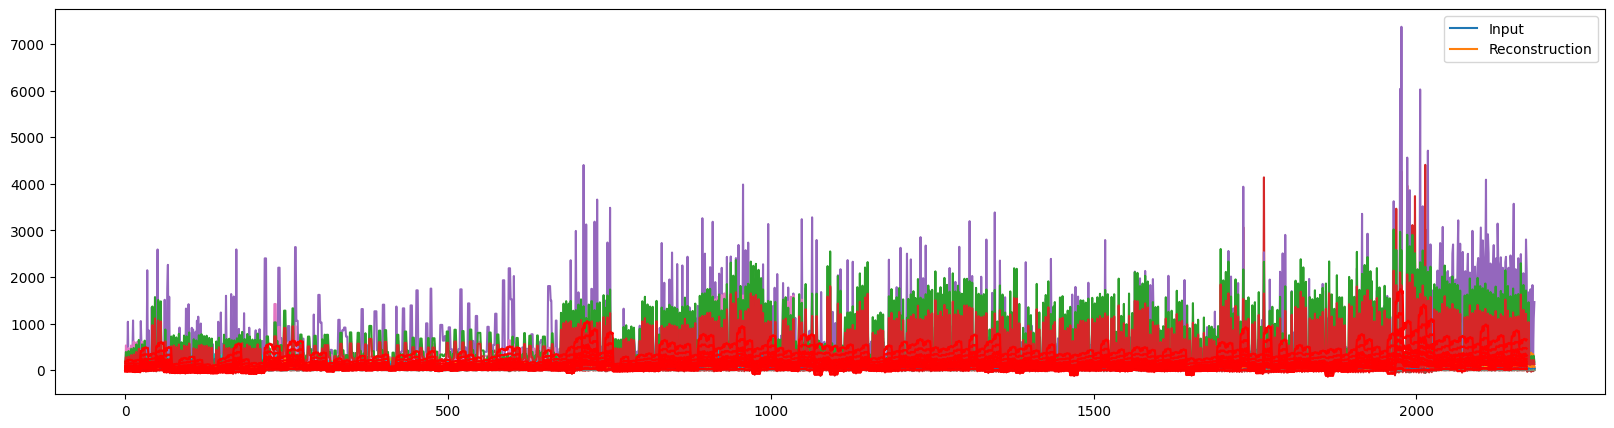

Epoch 1 Starting
Epoch 1 DONE


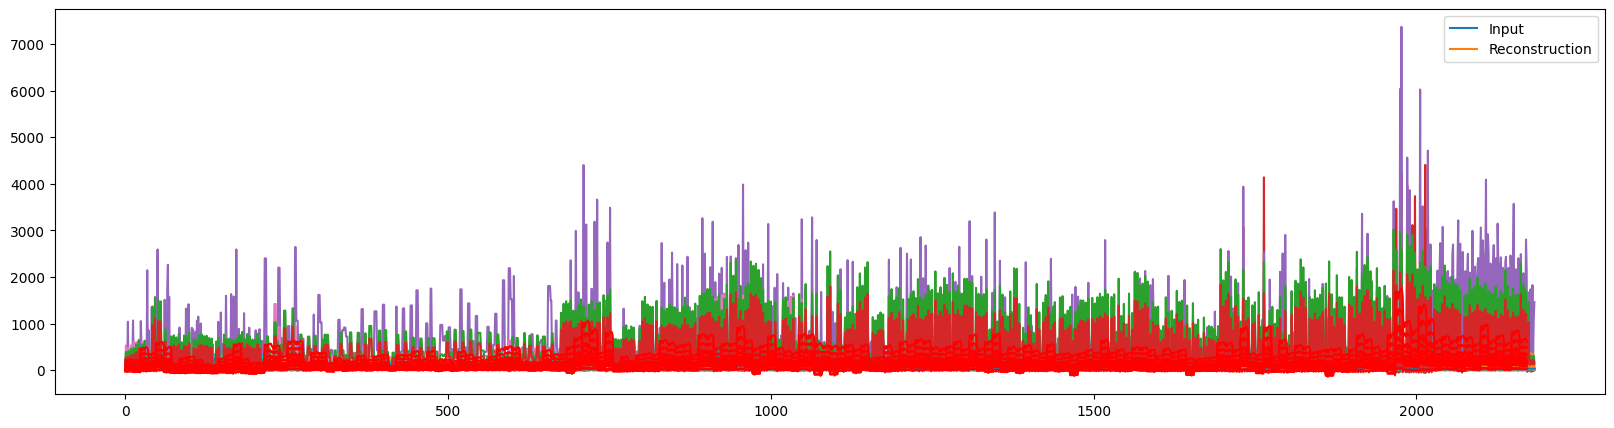

Epoch 2 Starting
Epoch 2 DONE


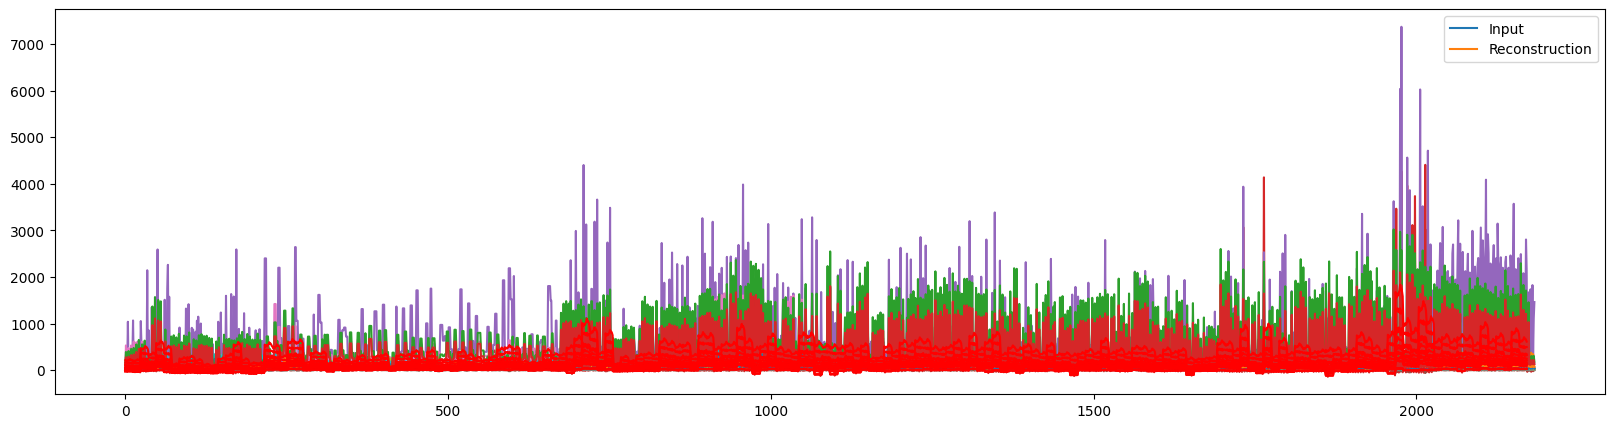

Epoch 3 Starting
Epoch 3 DONE


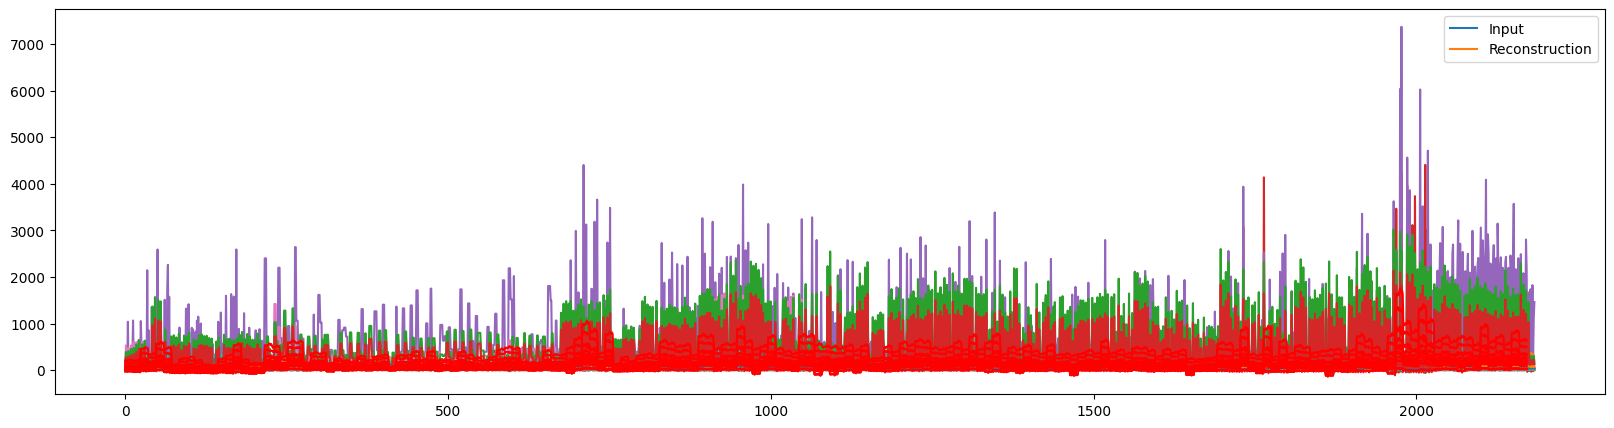

Epoch 4 Starting
Epoch 4 DONE


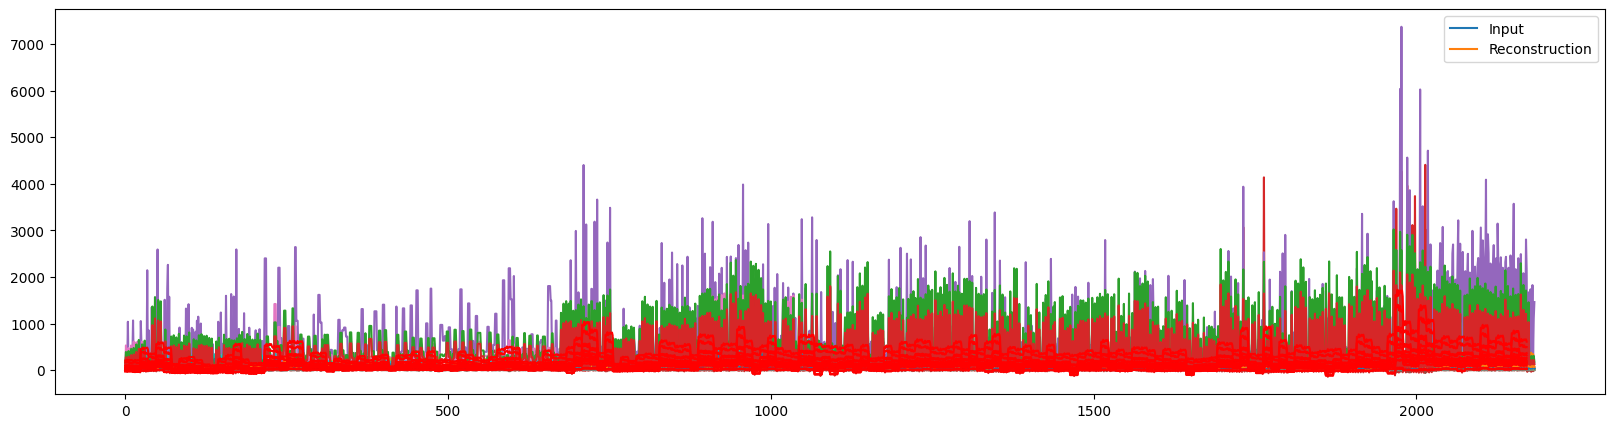

Epoch 5 Starting
Epoch 5 DONE


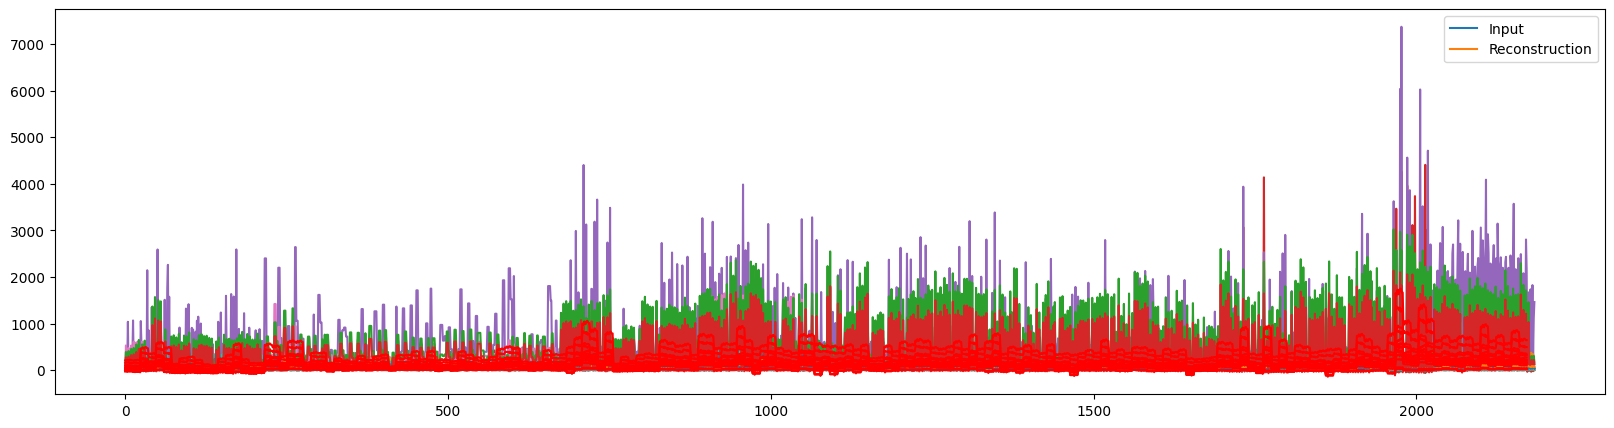

Epoch 6 Starting
Epoch 6 DONE


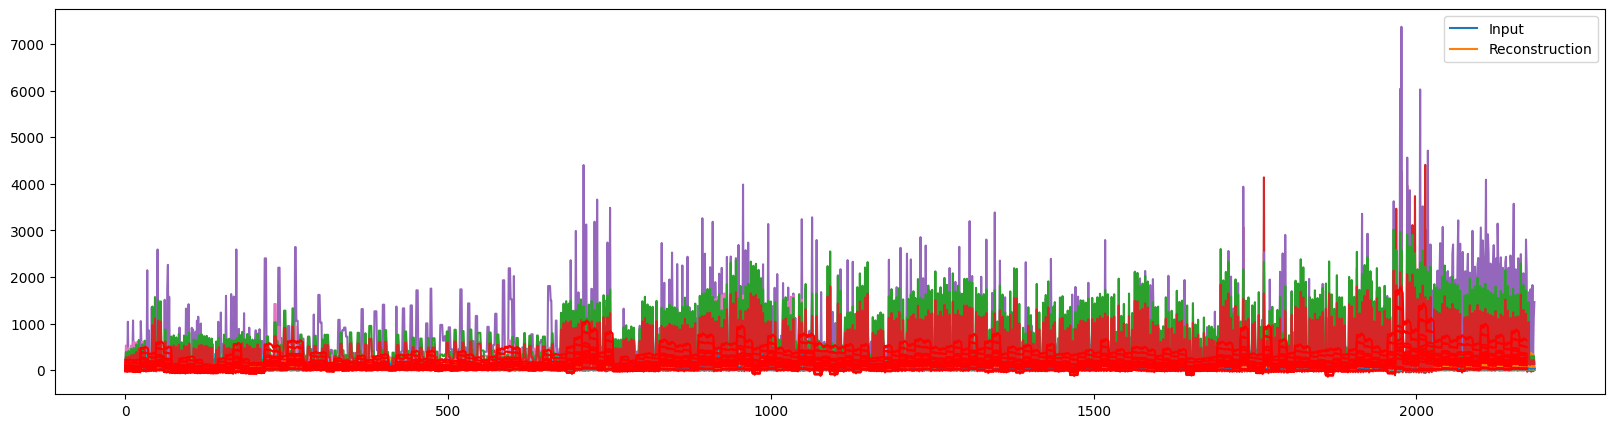

Epoch 7 Starting
Epoch 7 DONE


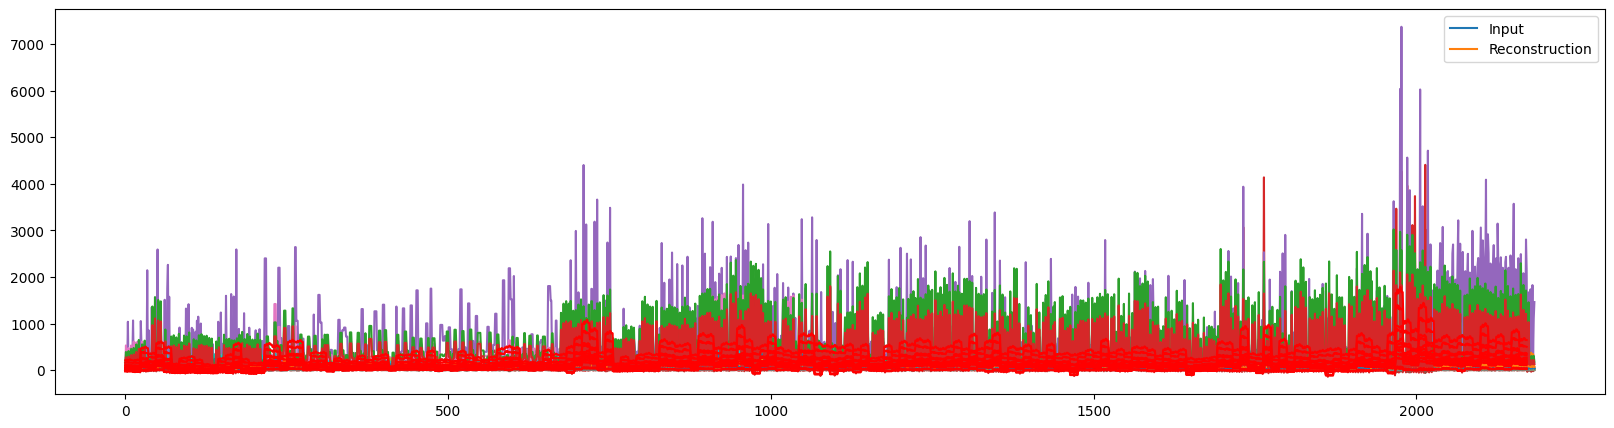

Epoch 8 Starting
Epoch 8 DONE


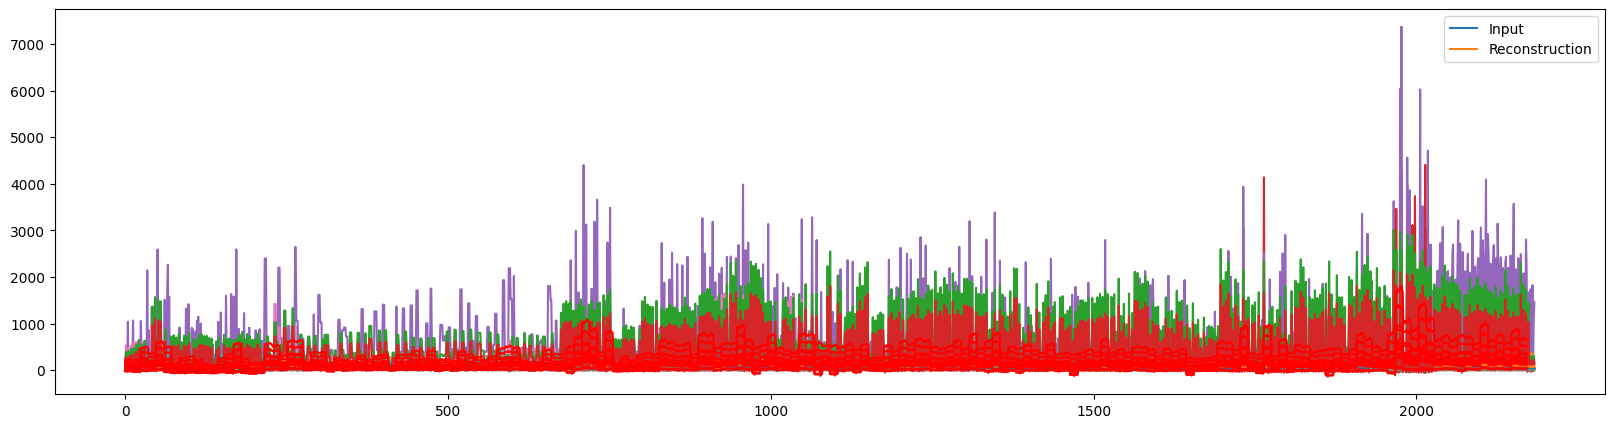

Epoch 9 Starting
Epoch 9 DONE


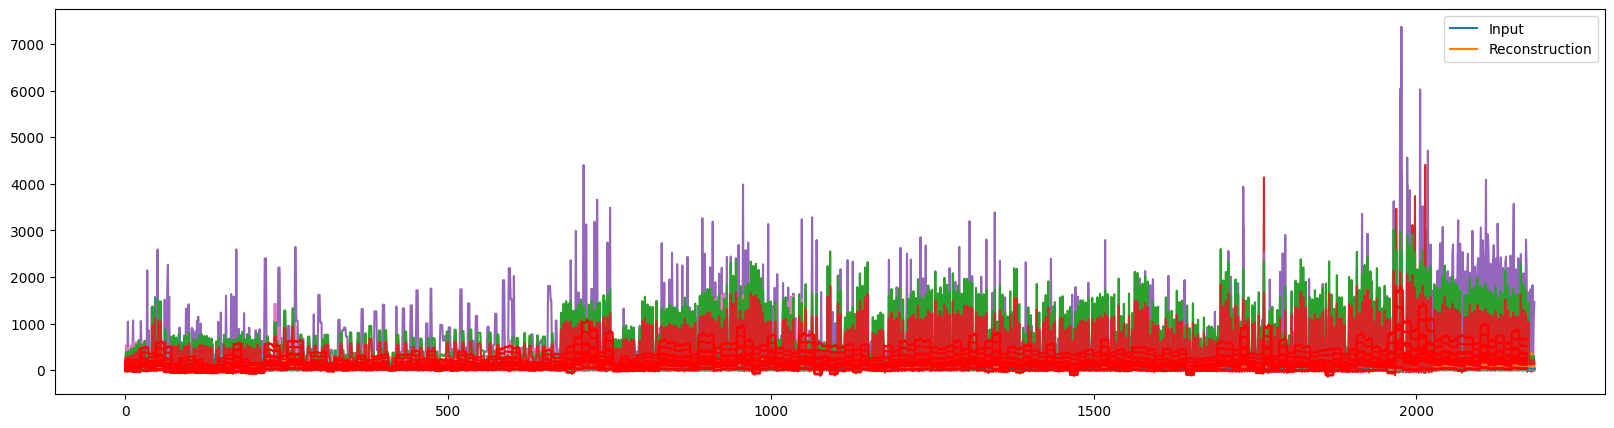

Epoch 10 Starting
Epoch 10 DONE


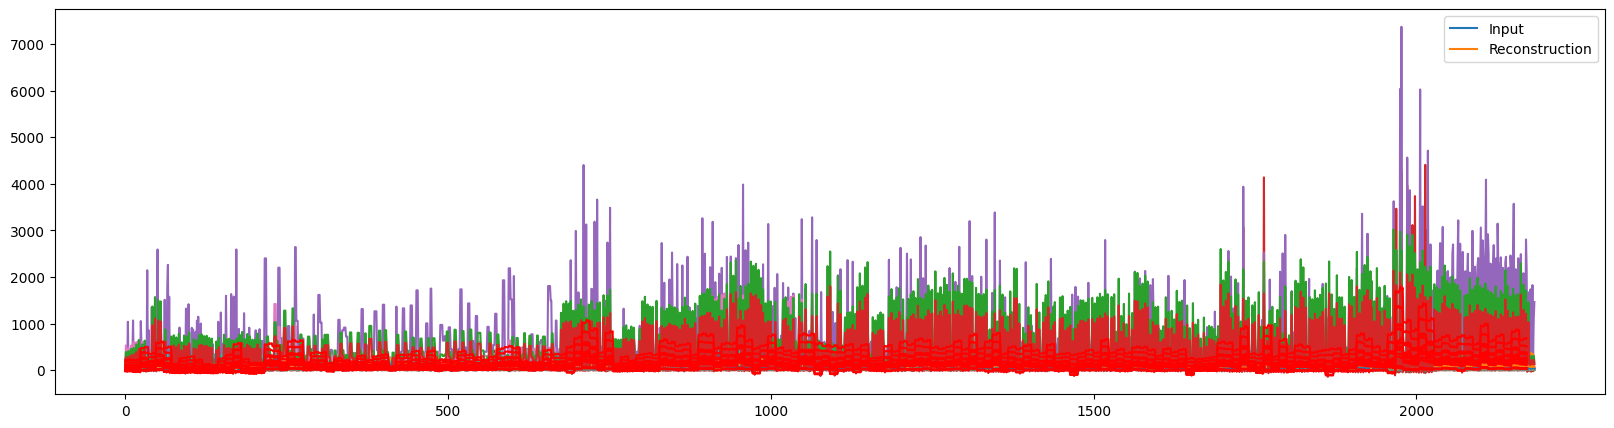

Epoch 11 Starting
Epoch 11 DONE


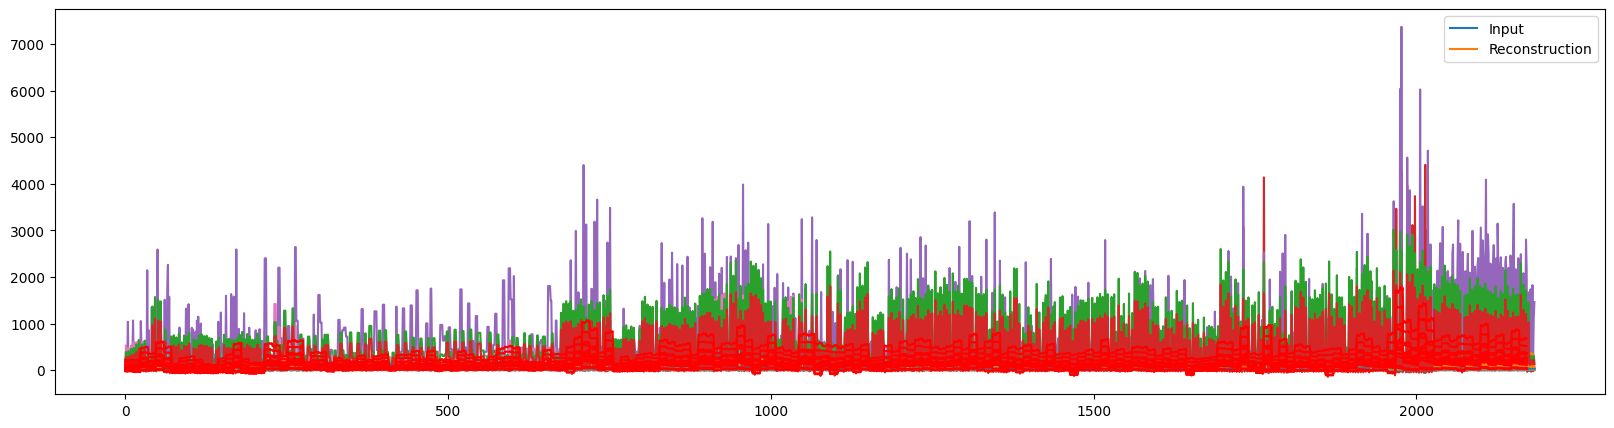

Epoch 12 Starting
Epoch 12 DONE


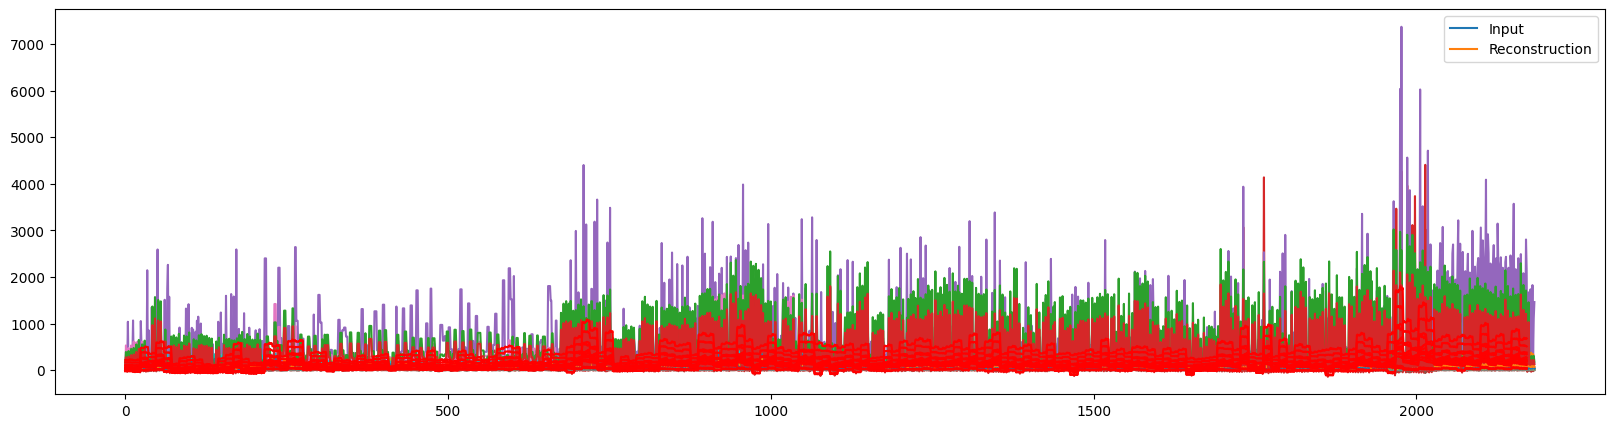

Epoch 13 Starting
Epoch 13 DONE


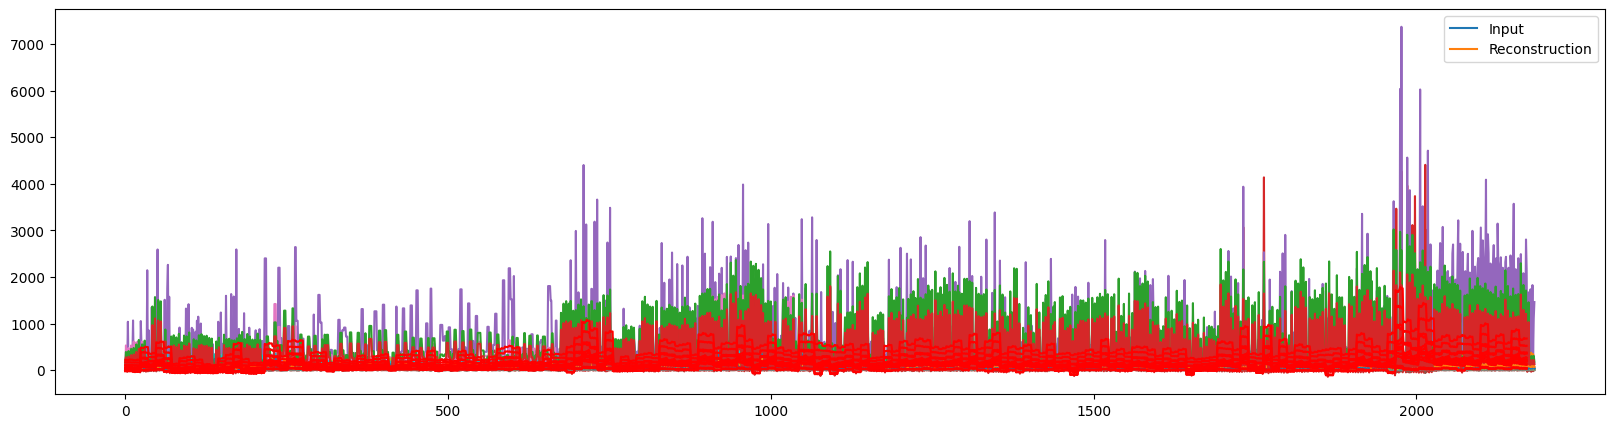

Epoch 14 Starting
Epoch 14 DONE


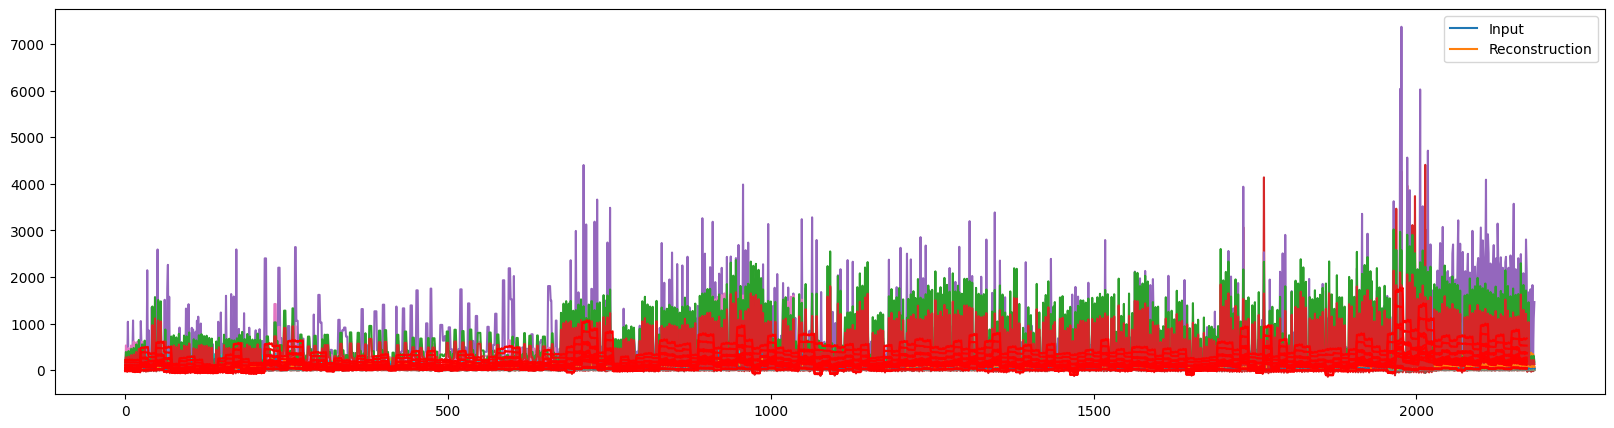

Epoch 15 Starting
Epoch 15 DONE


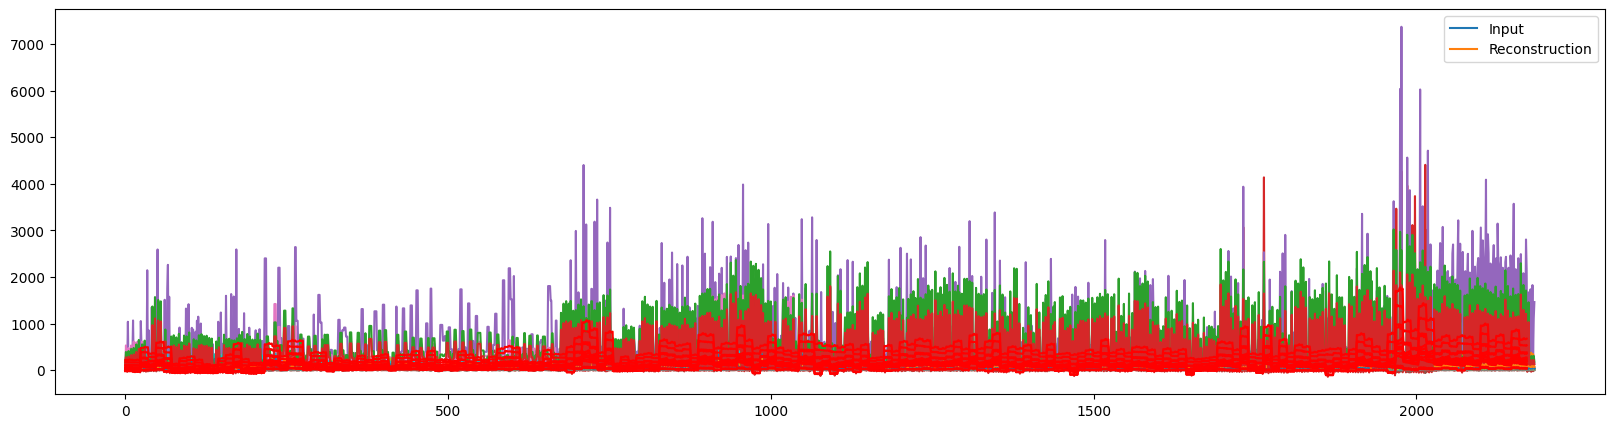

Epoch 16 Starting
Epoch 16 DONE


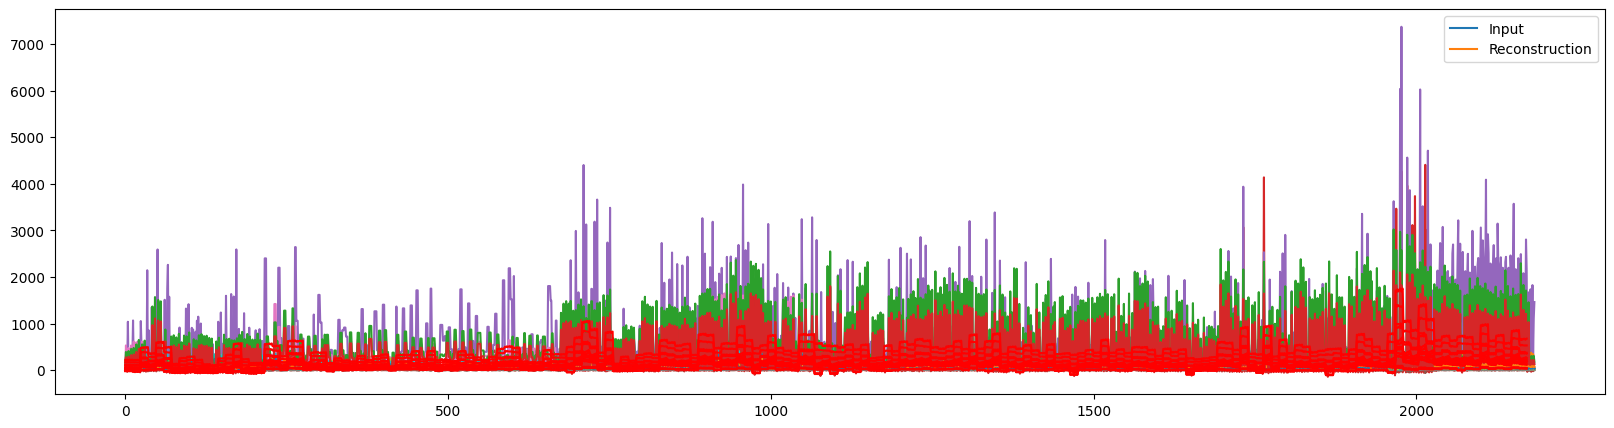

Epoch 17 Starting
Epoch 17 DONE


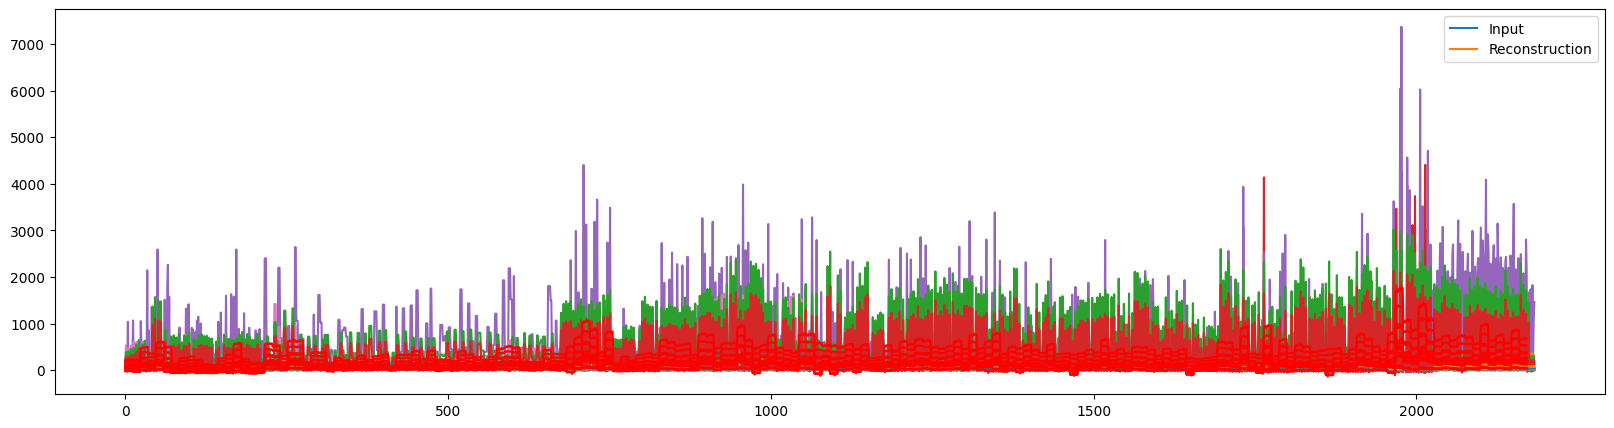

Epoch 18 Starting
Epoch 18 DONE


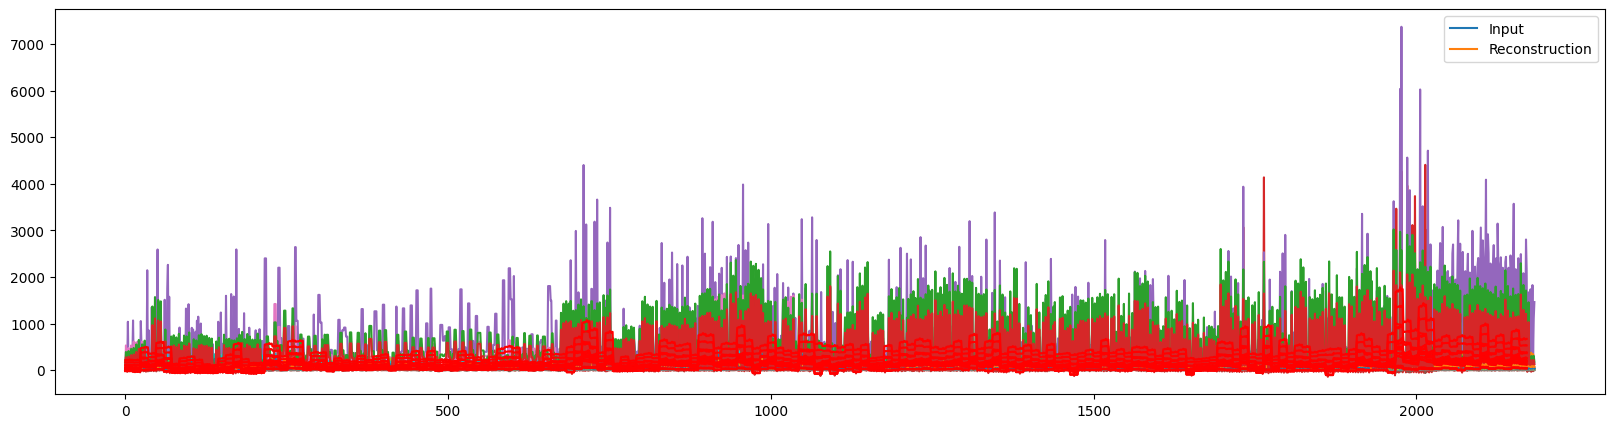

Epoch 19 Starting
Epoch 19 DONE


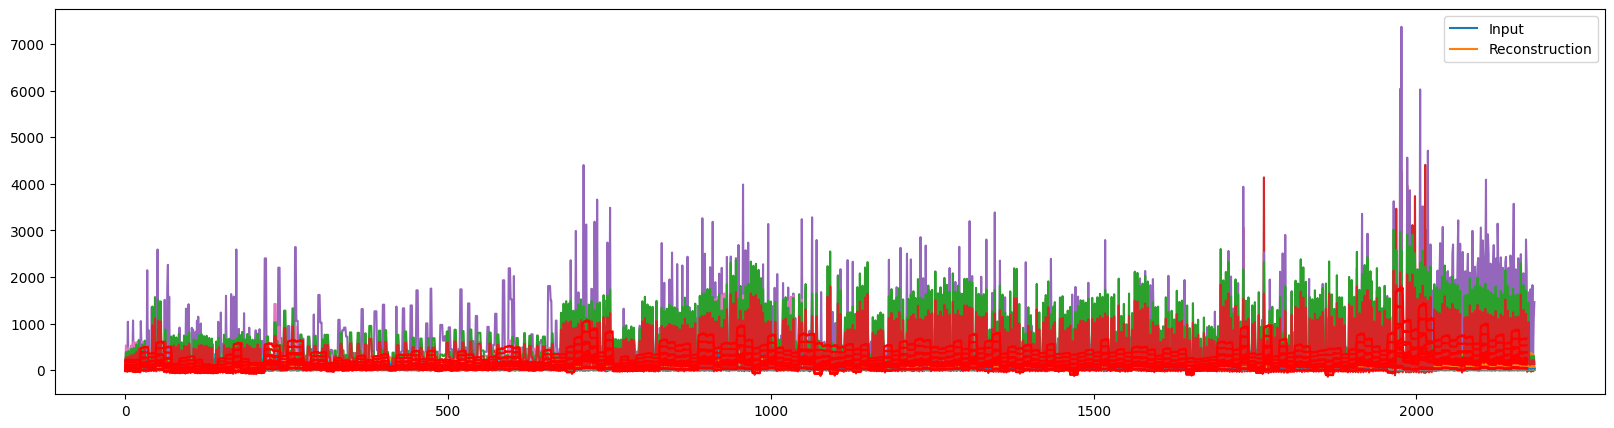

In [ ]:
step = 0
for epoch in range(max_epochs):
  print("Epoch " + str(epoch) +" Starting")

  for frame in train_data:
    with tf.GradientTape() as gen_tape:
      output = generator(np.array([frame]))
      disc_output = discriminator(np.array(output))
     
      mae = tf.keras.losses.MeanAbsoluteError() 
      gen_loss = mae(frame, output[0]) * -disc_output[0][0]

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))

  print("Epoch " + str(epoch) +" DONE")
  plotUsingAutoEncoder(generator)


In [ ]:
denoised_velocities = pd.read_csv('/content/denoised_velocities.csv')

In [ ]:
denoised_velocities.head()

In [ ]:
df['XOAVelocity'][220:650]

In [ ]:
num=np.mean(np.square(df['XOAVelocity'][220:650]))

In [ ]:
length = len(df['XOAVelocity'][220:650])

In [ ]:
li =[]
li2 = df['XOAVelocity'][220:650].values.tolist()   #original
li3=denoised_velocities['denoised_XOAVelocity'][220:650].values.tolist()   #separated
for i in range(length):
  li.append(li2[i] - li3[i])

li

In [ ]:
separated = pd.DataFrame(li, columns=['separated'])

In [ ]:
den=np.mean(np.square(separated))

In [ ]:
10 * np.log10(num / den)